In [7]:
import sklearn ,pandas as pds 
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

'''加载鸢尾花数据集'''
data = sklearn.datasets.load_iris()
X= np.array(data['data'])
Y = [y for y in  data['target']]
tn = ['setosa', 'versicolor', 'virginica']
'''归一化'''
X = (X-X.min(0))/(X.max(0)-X.min(0)) 

# 网络定义

## 模糊层

In [8]:
class FurzzyLear(nn.Module):
    
    def Furzzy(self,in_v):
        # print()
        xrange = torch.linspace(0,1,self.Fuz_size) 
        def getNormal( u,sigma,x=xrange ):
            '''高斯分布（正态分布）'''
            r = (-(xrange-u)**2/2/sigma**2)
            return torch.pow(torch.Tensor([torch.e]),r)/(np.sqrt(2*torch.pi)*sigma)
                
        arr=[]
        if len(in_v.shape) == 1:
            for i in in_v :
                arr.extend(getNormal(i,self.sigma))
            return torch.FloatTensor(arr)
        else:
            for j in in_v:
                line = []
                for i in j :
                    line.extend(getNormal(i,self.sigma))
                arr.append(line)
            return torch.FloatTensor(arr)

    def __init__(self,input_size , Fuz_size,Furzzyfunc=None):
        super(FurzzyLear, self).__init__()
        self.sigma=0.1
        self.Fuz_size =Fuz_size
        if Furzzyfunc is None:
            self.FuncFurzzy=self.Furzzy 
        else:
            self.FuncFurzzy=Furzzyfunc

    def forward(self,x):
        return self.FuncFurzzy(x)


## 主神经网络

In [9]:
class Net(nn.Module):
    def __init__(self,input_size ,output_size,Fuz_size=32,Furzzyfunc=None  ):
        super(Net, self).__init__()
        
        '''模糊层'''
        # 特征向量->无梯度张量。
        self.fl = FurzzyLear(input_size,Fuz_size)

        #全连接层，用于短路掉模糊层， 
        #实验不使用模糊矩阵算法时的推理效果
        self.BypassFurzzyLear = nn.Sequential(
            nn.Linear(input_size, input_size*Fuz_size),
            nn.ReLU(),
        )
      
        ''' 
        全连接推理层,
        '''
        self.FCN = nn.Sequential(
            nn.Linear(input_size*Fuz_size, input_size*Fuz_size,),
            nn.ReLU(),
            nn.Linear(input_size*Fuz_size, input_size*Fuz_size,),
            nn.ReLU(),
            # nn.Linear(input_size*Fuz_size, input_size*Fuz_size,),
            # nn.ReLU(),
        )
        
        #清晰化层
        self.uFuzL= nn.Linear(input_size*Fuz_size, output_size)

        #输出层
        self.lout = nn.Softmax(dim=0)
        
    def forward(self, x):
        
        '模糊层'
        x = self.fl(x) 
        # x = self.BypassFurzzyLear(x)

        '全连接推理'
        x=self.FCN(x)
        '退模糊层-输出层'
        x =F.sigmoid( self.uFuzL(x))
        '''
            softmax层输出，交叉熵不需要这一层
            最后用torch.argmax 提取概率最大的分类值即可。
        '''
        # x =  self.lout(x)
        return x

# 训练

In [11]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from poutyne import Model
import torch
import torch.nn as nn
import numpy as np

def train(sigma=0.01,fuz_zise=32,epochs=10,test_size=0.01,device='cpu'):

    
    '''
    训练时重置数据集和神经网络，防止混淆、重训练
    '''
    net  = Net(4,3,Fuz_size=fuz_zise) # 默认模糊层是正态分布，sigma=0.1 
    net.fl.sigma=sigma
    xtrain,xtest,ytrain,ytest =sklearn.model_selection.train_test_split(X,Y,test_size=test_size,random_state=100)
    ytrain = torch.LongTensor(ytrain)
    ytest = torch.LongTensor(ytest)
    xtrain = torch.FloatTensor(xtrain)
    xtest = torch.FloatTensor(xtest)

    model = Model(net, 'adam', 'cross_entropy',
                batch_metrics=['accuracy'], epoch_metrics=['f1'],device=device)
    trainlog = model.fit(
        xtrain, ytrain,
        validation_data=(xtrain, ytrain),
        epochs=epochs,
        batch_size=5 
        )

    l,vl,acc,vacc =[], [],[], []
    for i in trainlog:
        l.append(i['loss'])
        vl.append(i['val_loss'])
        acc.append(i['acc'])
        vacc.append(i['val_acc'])

    plt.figure(figsize=(10,5))
    grid = plt.GridSpec(2, 2, wspace=0.5, hspace=0.5)
    plt.subplot(grid[0,0])
    plt.title('T-loss')
    plt.plot(l )
    plt.subplot(grid[1,0])
    plt.plot(vl)
    plt.title('V-loss')
    p= net(xtest) 
    p = [int(torch.argmax(i))for i in p]
    aix = plt.subplot(grid[:,1],)
    aix.set_title(f'sigma={net.fl.sigma}')
    disp = ConfusionMatrixDisplay(confusion_matrix(ytest,p) ,display_labels=tn)
    disp.plot(cmap=plt.cm.Blues,ax=aix)
    plt.show()


Epoch: 1/5 Step:  1/24   4.17% |▊                   |ETA: 0.18s loss: 1.095824 acc: 40.000000

Epoch: 1/5 Train steps: 24 Val steps: 24 0.33s loss: 0.892435 acc: 78.333334 fscore_macro: 0.781083 val_loss: 0.679926 val_acc: 96.666667 val_fscore_macro: 0.966460
Epoch: 2/5 Train steps: 24 Val steps: 24 0.40s loss: 0.622782 acc: 95.833333 fscore_macro: 0.957924 val_loss: 0.589913 val_acc: 95.833333 val_fscore_macro: 0.958211
Epoch: 3/5 Train steps: 24 Val steps: 24 0.38s loss: 0.587890 acc: 95.833333 fscore_macro: 0.958442 val_loss: 0.579781 val_acc: 97.500000 val_fscore_macro: 0.975172
Epoch: 4/5 Train steps: 24 Val steps: 24 0.34s loss: 0.579468 acc: 96.666667 fscore_macro: 0.966952 val_loss: 0.575541 val_acc: 97.500000 val_fscore_macro: 0.975065
Epoch: 5/5 Train steps: 24 Val steps: 24 0.33s loss: 0.584660 acc: 96.666667 fscore_macro: 0.966667 val_loss: 0.575041 val_acc: 97.500000 val_fscore_macro: 0.975248


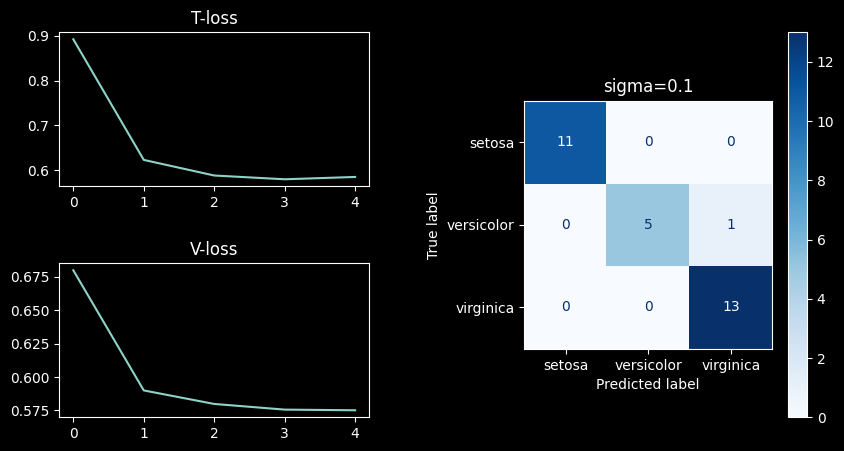

In [21]:
train(sigma=0.1,fuz_zise=32,epochs=5,test_size=0.2,device='cpu')

In [97]:
R = torch.FloatTensor([[1,2,3,4],[5,6,7,8],[9,10,11,12]])
# w = nn.Linear(3,1,bias=False) 

R=R.transpose(1,0)
# 这就是R*W  可以训出一个W来
w(R)


0.3890+5* 0.0225+9* 0.1449
2*0.3890+6* 0.0225+10* 0.1449

tensor([[1.8054],
        [2.3617],
        [2.9181],
        [3.4745]], grad_fn=<MmBackward0>)


2.362